<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

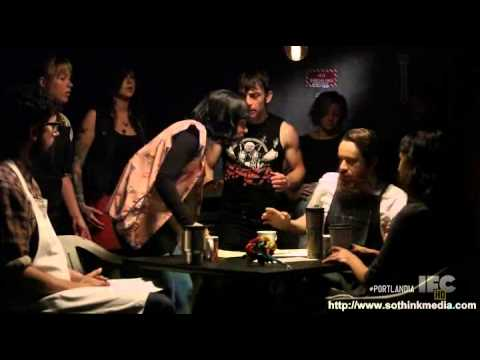

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/serinagrill/Documents/repos/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
# Load and take a look at our data 
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [4]:
# View the raw text
shops.full_review_text.value_counts(normalize=True)[:5]

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

 10/7/2016 1 check-in Marymint Monroe  + Chicken and waffles samich = my favorite cafe in Austin.  ... Ohhh and decor is pretty sweet too                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.000525
 10/16/2016 My only complaint 

In [5]:
# Cast star_rating column to numeric to make it easier to work with 
shops['star_rating'] = shops['star_rating'].map({' 5.0 star rating ': 5, ' 4.0 star rating ': 4, ' 3.0 star rating ': 3, ' 2.0 star rating ': 2, ' 1.0 star rating ': 1})

In [6]:
#Import and load spacy 
import spacy

nlp = spacy.load("en_core_web_lg")

In [7]:
from collections import Counter

# Useful count function
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    total_docs = len(docs)
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [8]:
# Customize stop words as necessary 
STOP_WORDS = nlp.Defaults.stop_words.union([' ', '-', '1', "i'm", "i've", "it's"])

In [9]:
### Lemmas function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ == 'ADJ'):
                lemmas.append(token.lemma_)
    
    return lemmas

In [10]:
# Apply lemmas function 
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [12]:
# Apply count function to 'good' coffee shops to get 'good' df
good_wc = count(shops[shops['star_rating'] > 3]['lemmas'])

# Get highest ranked words of 'good' coffee shops
good_wc_top20 = good_wc[good_wc['rank'] <= 20]

In [16]:
import squarify
import matplotlib.pyplot as plt

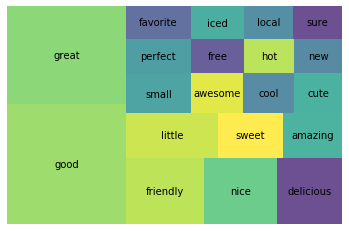

In [17]:
# Plot highest ranked adjectives associated with 'good' coffee shops
squarify.plot(sizes=good_wc_top20['pct_total'], label=good_wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [19]:
# Apply count function to 'bad' coffee shops to get 'bad' df
bad_wc = count(shops[shops['star_rating'] < 4]['lemmas'])

# Get highest ranked words of 'bad' coffee shops
bad_wc_top20 = bad_wc[bad_wc['rank'] <= 20]

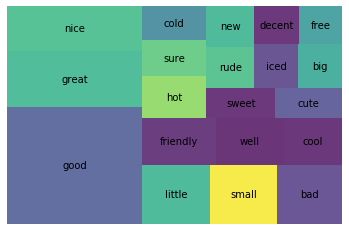

In [20]:
# Plot highest ranked adjectives associated with 'bad' coffee shops
squarify.plot(sizes=bad_wc_top20['pct_total'], label=bad_wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [26]:
# Merge our 'good' and 'bad' df with just the necessary columns 
differences = good_wc[['word', 'appears_in_pct']].merge(bad_wc[['word', 'appears_in_pct']], on='word', suffixes=('_good', '_bad'))

In [32]:
# Create a new column that shows us the differences in appears_in_pct_good and appears_in_pct_bad
differences['diffs'] = differences['appears_in_pct_good'] - differences['appears_in_pct_bad'].sort_values()

In [35]:
# Sort the values to view the highest differences
differences.sort_values(by='diffs').head(10)

,word,appears_in_pct_good,appears_in_pct_bad,diffs
42,bad,0.036645,0.128726,-0.092081
344,rude,0.003094,0.063686,-0.060591
24,well,0.057166,0.114499,-0.057333
136,disappointed,0.011238,0.051491,-0.040253
159,okay,0.009609,0.048103,-0.038494
192,ok,0.006840,0.044038,-0.037198
123,expensive,0.012866,0.047425,-0.034559
56,decent,0.029967,0.064363,-0.034396
8,small,0.103420,0.132114,-0.028694
121,wrong,0.012866,0.041328,-0.028461


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

